In [ ]:
!pip install bert-for-tf2
# !pip install keras==2.3.1
!pip install tensorflow_hub
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30509 sha256=9f02151c184ec2cdc97d5f7711347bd841bf10180422de5d6d1ca0312145ab4b
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19454 sha256=4f6cac801dacd31c7873fc6dd0c2d890e475fa2c2b0cf71f1b8656798ee90559
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=309e889a641c1e8078e4aa72ff4a5292421aa5bf911397cbc2203a576942eea4
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [ ]:
!pip install pydot
!pip install graphviz

In [ ]:
# Import all necessary libraries
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2, l1
#from kerastuner.tuners import Hyperband
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout,Dense, Input, Bidirectional,LSTM,Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

#  MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers, initializers
import bert

import shutil
import numpy as np
import pandas as pd
import re
import glob
import os
import cv2
import sys
import pickle
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data_image.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_image/california_wildfires/12_10_2017/918312987299012608_0.jpg  
  inflating: __MACOSX/data_image/california_wildfires/12_10_2017/._918312987299012608_0.jpg  
  inflating: data_image/california_wildfires/24_10_2017/922820740503801856_0.jpg  
  inflating: __MACOSX/data_image/california_wildfires/24_10_2017/._922820740503801856_0.jpg  
  inflating: data_image/california_wildfires/24_10_2017/922924297533865984_0.jpg  
  inflating: __MACOSX/data_image/california_wildfires/24_10_2017/._922924297533865984_0.jpg  
  inflating: data_image/california_wildfires/24_10_2017/922952858235944961_0.jpg  
  inflating: __MACOSX/data_image/california_wildfires/24_10_2017/._922952858235944961_0.jpg  
  inflating: data_image/california_wildfires/24_10_2017/922830395548172288_0.jpg  
  inflating: __MACOSX/data_image/california_wildfires/24_10_2017/._922830395548172288_0.jpg  
  inflating: data_image/california_wildfires/24_10_2017/92263302

In [ ]:
use_labels = ["not_humanitarian", "other_relevant_information",
              "rescue_volunteering_or_donation_effort",
              "infrastructure_and_utility_damage", "affected_individuals"]

In [ ]:
train_df = pd.read_table('/content/drive/MyDrive/data_train.tsv')
validation_df = pd.read_table('/content/drive/MyDrive/data_val.tsv')


In [ ]:
def change_label(x):
    if x not in use_labels:
        return "affected_individuals"
    else:
        return x

In [ ]:

# Apply the change_label function to the 'label' column
train_df["label"] = train_df["label"].apply(lambda x: change_label(x))
validation_df["label"] = validation_df["label"].apply(lambda x: change_label(x))


In [ ]:
def get_df(df, type_):
    D = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        file = row["image"]
        tweet_text = row["tweet_text"]
        label = row["label"]

        # Prepending /content/drive/MyDrive/ to the file path
        full_file_path = f"{file}"

        new_file = "_".join(file.split("/")[-2:])

        # Check if the directory exists, if not, create it
        if not os.path.exists(f"data/{type_}/{label}"):
            os.makedirs(f"data/{type_}/{label}")

        # Copy the file to the new location with the updated path
        shutil.copy(full_file_path, f"data/{type_}/{label}/{new_file}")

        D.append([new_file, tweet_text, label])

    return pd.DataFrame(D, columns=["image_path", "text", "label"])


In [ ]:
train = get_df(train_df, "train")

val =get_df(validation_df,"val")

  0%|          | 0/5126 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
val.head()

image_path  \
0   11_9_2017_907378962879442944_0.jpg   
1    8_9_2017_906253859181473792_0.jpg   
2   17_9_2017_909486151760777216_0.jpg   
3  21_10_2017_921838065571844096_0.jpg   
4    5_6_2017_871808950798352385_0.jpg   

                                                text  \
0  S/O to OU FIJI for raising over $6,000 for hur...   
1  One more hat picture. 8th grade floor got afte...   
2  @donttrythis Irma knocked a lot of trees down ...   
3  @previouslife17 @ahlers58 @CREWcrew @WienerJaM...   
4  My mora mora á½ Dá½ Dá½ Dá½ D https://t.co/dg4...   

                                    label  
0  rescue_volunteering_or_donation_effort  
1                        not_humanitarian  
2       infrastructure_and_utility_damage  
3                        not_humanitarian  
4                        not_humanitarian

In [ ]:
train = train.set_index('image_path')

val= val.set_index('image_path')

In [ ]:
# Sort values by 'image_path'

train = train.sort_values('image_path')
val = val.sort_values('image_path')

In [ ]:
val.head()

text  \
image_path                                                                               
10_10_2017_917782103131152389_0.jpg  David Beddard of Bright Vision Mortgage FL. &a...   
10_10_2017_917782569436971008_0.jpg  Tim Dailey of Bright Vision Mortgage is happy ...   
10_10_2017_917811151320338433_0.jpg  RT @VABVOX: #California is on fire &amp; no on...   
10_10_2017_917836387155677185_0.jpg  RT @mashable: Striking satellite images show s...   
10_10_2017_917850123543171073_0.jpg  The world's only 747 supertanker is fighting C...   

                                                                      label  
image_path                                                                   
10_10_2017_917782103131152389_0.jpg                        not_humanitarian  
10_10_2017_917782569436971008_0.jpg                        not_humanitarian  
10_10_2017_917811151320338433_0.jpg       infrastructure_and_utility_damage  
10_10_2017_917836387155677185_0.jpg              other_relevant_information  
10_10_2017_917850123543171073_0.jpg  rescue_volunteering_or_donation_effort

In [ ]:
def get_missing(file, df):
    parts = file.split(os.sep)
    idx = parts[-1]
    cls = parts[-2]
    indexes = df[:,0]
    classes = df[:,2]

    if idx in indexes:
        text = df[idx == indexes][0,1]
        return pd.NA, pd.NA, pd.NA
    else:
        text = df[cls == classes][0,1]

    return idx, text, cls

vec_get_missing = np.vectorize(get_missing, signature='(),(m,n)->(),(),()')

In [ ]:
# Function for images loading
def add_not_found(path, df):
    files = glob.glob(path)
    df = df.reset_index()
    idxs, texts, cls = vec_get_missing(files, df.values)

    found = pd.DataFrame({"text": texts, "label": cls, "image_path": idxs})
    na = found.isna().sum().values[0]
    if na<found.shape[0]:
        df = df._append(found)
    df = df.drop_duplicates(subset='image_path', keep='first').dropna()
    df = df.set_index('image_path')
    df = shuffle(df, random_state = 0)
    return df

In [ ]:
# Images folders
train = add_not_found('data/train/*/*.jpg', train)


print("Number of training images:",train.shape[0])


Number of training images: 5126


In [ ]:
val = add_not_found('data/val/*/*.jpg', val)
print("Number of val images:",val.shape[0])

Number of val images: 1000


In [ ]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)

vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
# Precompiled regular expressions for performance
TAG_RE = re.compile(r'<[^>]+>')
PUNCTUATION_AND_NUMBERS_RE = re.compile('[^a-zA-Z]')
SINGLE_CHARACTER_RE = re.compile(r"\s+[a-zA-Z]\s+")
MULTIPLE_SPACES_RE = re.compile(r'\s+')
def preprocess_text(sen):
    """
    Clean and preprocess text by removing HTML tags, punctuations, numbers,
    single characters, and multiple spaces, and converting to lowercase.
    """
    # Removing html tags
    sentence = TAG_RE.sub('', sen)
    # Remove punctuations and numbers
    sentence = PUNCTUATION_AND_NUMBERS_RE.sub(' ', sentence)
    # Single character removal
    sentence = SINGLE_CHARACTER_RE.sub(' ', sentence)
    # Removing multiple spaces
    sentence = MULTIPLE_SPACES_RE.sub(' ', sentence)
    # Convert to lowercase
    sentence = sentence.lower().strip()
    return sentence

# Define the vectorized function with the signature indicating it takes and returns a scalar value
vec_preprocess_text = np.vectorize(preprocess_text, otypes=[np.object])


<ipython-input-100-ae6f874655e8>:24: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vec_preprocess_text = np.vectorize(preprocess_text, otypes=[np.object])


In [146]:
def get_tokens(text, tokenizer):
  tokens = tokenizer.tokenize(text)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  length = len(tokens)
  if length > max_length:
      tokens = tokens[:max_length]
  return tokens, length

def get_masks(text, tokenizer, max_length):
    """Mask for padding"""
    tokens, length = get_tokens(text, tokenizer)
    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))

def get_segments(text, tokenizer, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens, length = get_tokens(text, tokenizer)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))


def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids


def get_texts(path):
    path = path.decode('utf-8')
    parts = path.split(os.sep)
    image_name = parts[-1]
    is_train = parts[-3] == 'train'
    if is_train:
      text= train['text'][image_name]
    else:
      text = val['text'][image_name]
    return text
vec_get_masks = np.vectorize(get_masks, signature = '(),(),()->(n)')
vec_get_segments = np.vectorize(get_segments, signature = '(),(),()->(n)')
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')
vec_text = np.vectorize(get_texts)

In [153]:
def prepare_text(paths):
    #Preparing texts

    texts = vec_text(paths)

    text_array = vec_preprocess_text(texts)
    ids = vec_get_ids(text_array,
                      tokenizer,
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)

    return ids, segments, masks

def clean(i, tokens):
  try:
    this_token = tokens[i]
    next_token = tokens[i+1]
  except:
    return tokens
  if '##' in next_token:
      tokens.remove(next_token)
      tokens[i] = this_token + next_token[2:]
      tokens = clean(i, tokens)
      return tokens
  else:
    i = i+1
    tokens = clean(i, tokens)
    return tokens

def new_text(array):
  array = array[(array!=0) & (array != 101) & (array != 102)]
  tokens = tokenizer.convert_ids_to_tokens(array)
  tokens = clean(0, tokens)
  text = ' '.join(tokens)
  return text

In [148]:
def load_image(path, augment=False):
    path = path.decode('utf-8')
    image = cv2.imread(path)
    image = cv2.resize(image, (299, 299))
    image = np.expand_dims(image, axis=0)  # Expand dims to add batch size of 1
    image = image.astype(np.float32) / 255.0  # Rescale the image
    if augment:
        # Create an ImageDataGenerator instance with your augmentation parameters
        datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Apply the augmentation
        image = datagen.random_transform(image)

    parts = path.split(os.sep)
    labels = parts[-2] == Classes
    labels = labels.astype(np.int32)

    return image, labels

vec_load_image = np.vectorize(load_image, signature='()->(r,c,d),(s)')


In [154]:
# Dataset creation

def prepare_data(paths):
    #Images and labels
    images, labels = tf.numpy_function(vec_load_image,
                                      [paths],
                                      [tf.float32,
                                        tf.int32])


    [ids, segments, masks, ] = tf.numpy_function(prepare_text,
                                              [paths],
                                              [tf.int32,
                                               tf.int32,
                                               tf.int32])
    images.set_shape([None, img_width, img_height, depth])
    labels.set_shape([None, nClasses])
    ids.set_shape([None, max_length])
    masks.set_shape([None, max_length])
    segments.set_shape([None, max_length])
    return ({"input_word_ids": ids,
             "input_mask": masks,
             "segment_ids": segments,
             "image": images},
            {"class": labels})


    return dataset

In [149]:
# Parameters setting: images width and height, depth, number if classes, input shape
batch_size =  64
img_width = 299
img_height = 299
depth = 3
max_length = 20 #Setup according to the text

nClasses = train.label.nunique()
Classes = train.label.unique()
input_shape = (img_width, img_height, depth)

In [ ]:
nClasses

5

In [155]:


def tf_data(path, batch_size):
    return (tf.data.Dataset.list_files(path)
            .batch(64)
            .map(prepare_data, tf.data.experimental.AUTOTUNE)
            .prefetch(tf.data.experimental.AUTOTUNE)
            .unbatch()
            .batch(batch_size))
data_train = tf_data('data/train/*/*.jpg', batch_size)
data_val = tf_data('data/val/*/*.jpg',batch_size)

In [142]:
data_val

<_BatchDataset element_spec=({'input_word_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'segment_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'image': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None)}, {'class': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None)})>

In [157]:
ip, op = next(iter(data_train))
images = ip['image'][:16]
input_word_ids = ip['input_word_ids'][:16]
true_labels =  op['class'][:16]

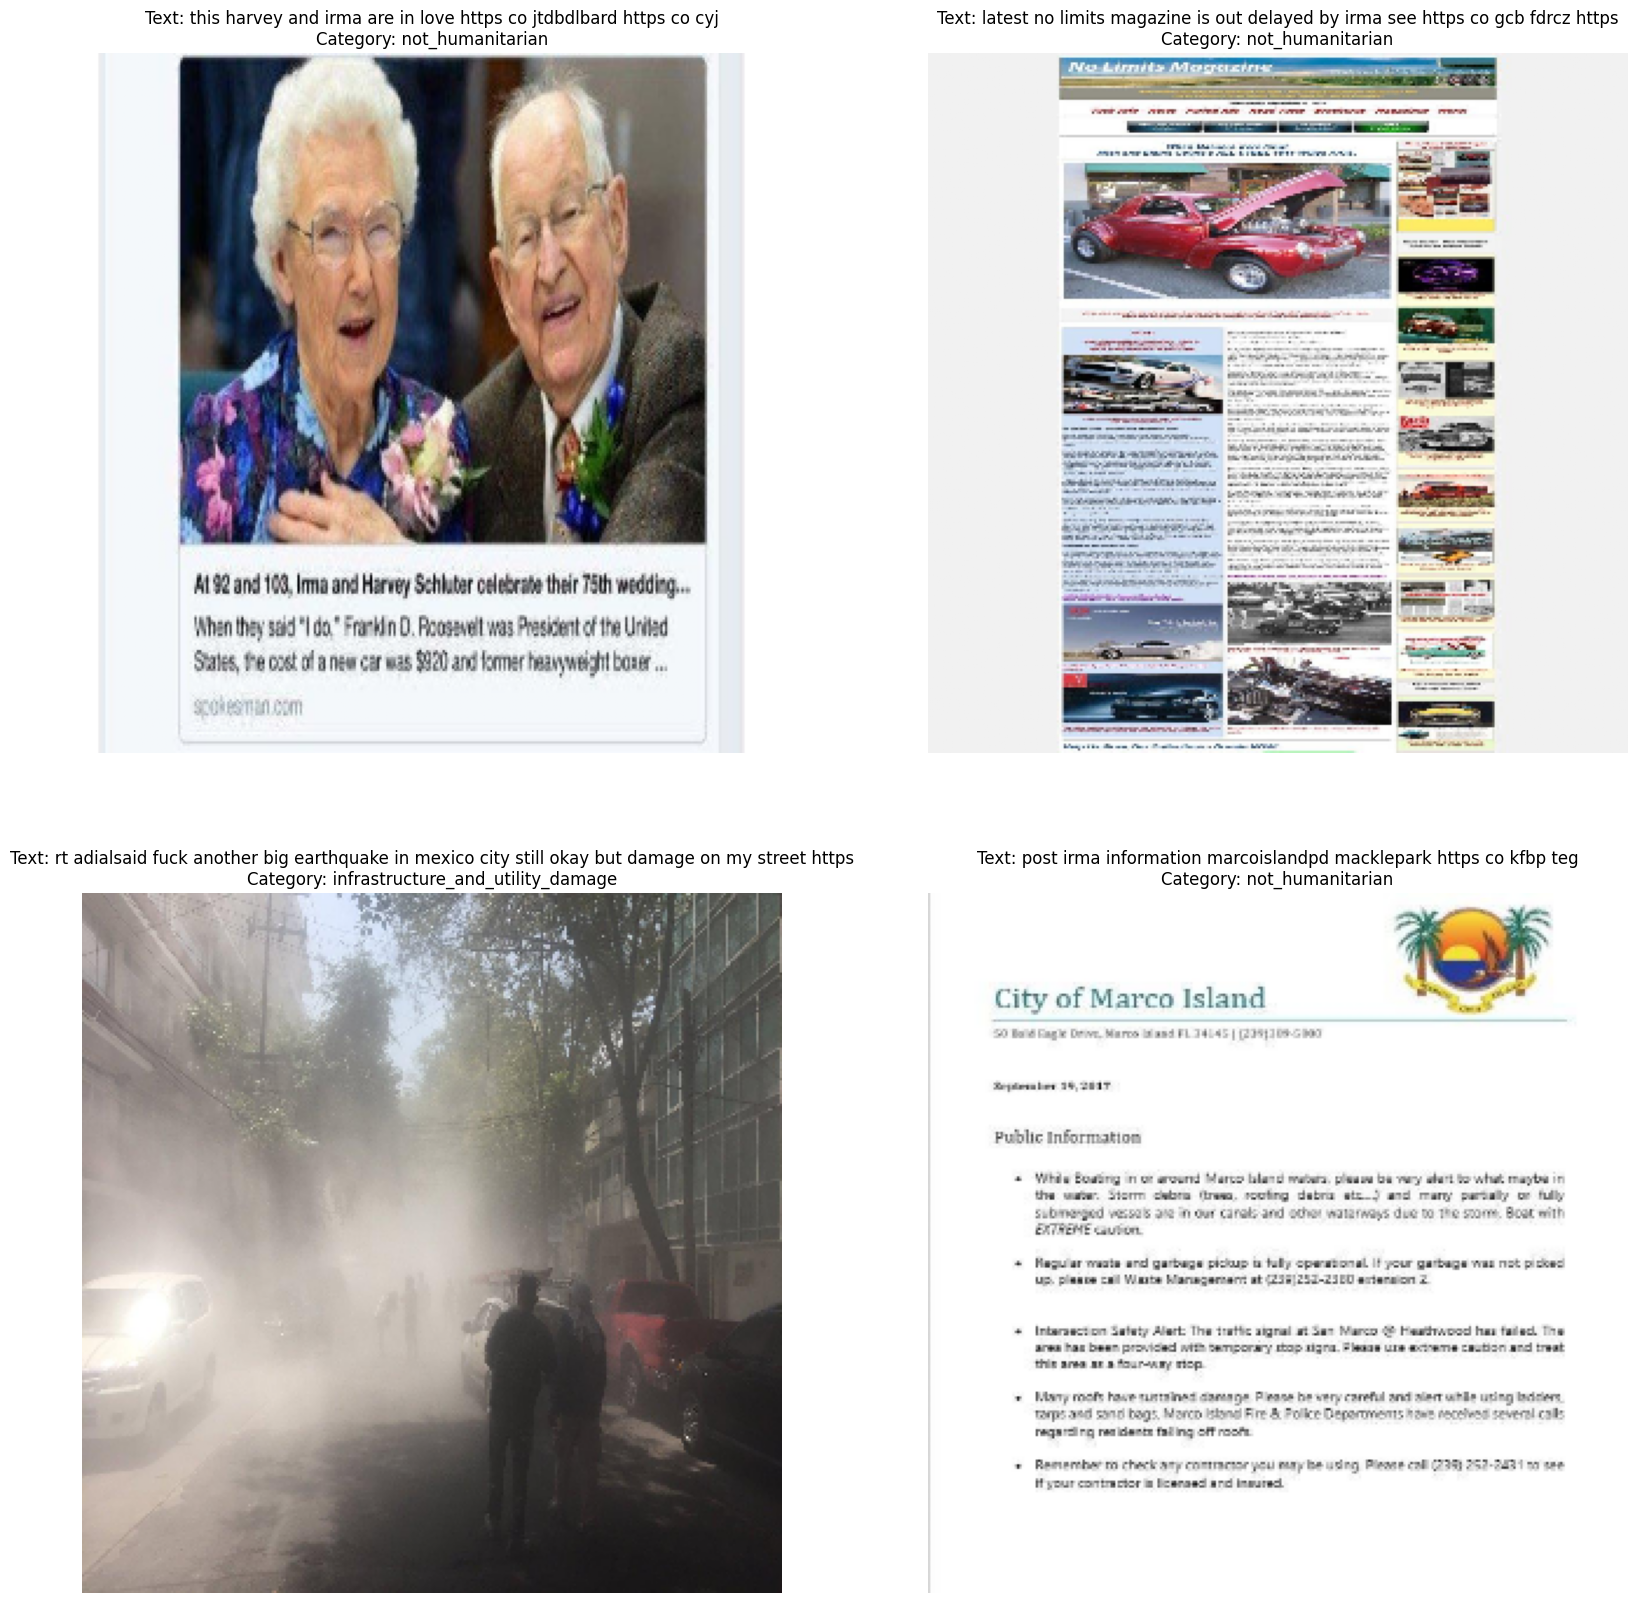

In [158]:
# Print images and related texts before classification

i=1
texts = [new_text(array) for array in input_word_ids.numpy()]
plt.figure(figsize=(20,20))
for image, label, text in zip(images.numpy()[:4], true_labels.numpy()[:4], texts):
    plt.subplot(2,2,i)
    i+=1
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Text: {}\nCategory: {}".format(text, Classes[label.argmax(0)]))
plt.show()

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import Hyperband
from tensorflow.keras.models import Sequential


<ipython-input-34-c2fc43adfb3a>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [ ]:
text_features_flatten.shape

TensorShape([None, 256])

In [133]:
# model new
# 1217
def build_model( hp,seq_out):
    input_shape = (299,299, 3)
    max_length = 20
    nClasses=5
     # Replace the fixed hyperparameter values with search spaces
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)


    base_model= MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    for layer in base_model.layers:
            layer.trainable = False
    model_cnn = models.Sequential([
        base_model,
        GlobalAveragePooling2D(name='AVG_Pooling'),
        BatchNormalization(),  # Add BatchNormalization layer
        Dropout(0.4, name='Dropout'),
        Dense(128, activation='relu', name='Dense_128'),
        BatchNormalization(),  # Optionally add another BatchNormalization layer after the Dense layer
    ])

    # BiLSTM Model


    out = layers.Bidirectional(layers.LSTM(128, kernel_regularizer=l2(0.01),name='BiLSTM'))(seq_out)

    model_bilstm = models.Model([input_ids, input_masks, input_segments], out)


    # Concatenation
    input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_mask")
    segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                        name="segment_ids")
    image_input = layers.Input(shape = input_shape, dtype=tf.float32,
                               name = "image")

    image_side = model_cnn(image_input)
    text_side = model_bilstm([input_word_ids, input_mask, segment_ids])
    merged = Concatenate()([image_side, text_side])
    combined = layers.BatchNormalization(momentum=0.9)(merged)

    num_heads = 4  # Example: Choose a number that divides feature_dim evenly
    key_dim = 128
    sequence_length = 1  # Define based on your model's requirements


    feature_dim = combined.shape[-1]  # Assuming the last dimension is the feature dimension
    combined_reshaped = layers.Reshape((sequence_length, feature_dim))(combined)

    # Add MultiHeadAttention layer
    # Ensure combined_reshaped is used
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        combined_reshaped, combined_reshaped, combined_reshaped
    )

    attention_output_reshaped = layers.Reshape(combined.shape[1:])(attention_output)

    # Combine the attention output with the original combined features (Skip Connection)
    combined_with_attention = layers.Add()([combined, attention_output_reshaped])
    merged = layers.Dense(384, activation = 'relu')(combined_with_attention)
    output = Dense(nClasses, activation='softmax', name="class")(merged)
    model = models.Model([input_word_ids, input_mask, segment_ids, image_input], output)

    # Compile model
    model.compile(
        optimizer = Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [159]:
# model new
# 1217
def build_model( seq_out):
    input_shape = (299,299, 3)
    max_length = 20
    nClasses=5


    base_model= MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    for layer in base_model.layers:
            layer.trainable = False
    model_cnn = models.Sequential([
        base_model,
        GlobalAveragePooling2D(name='AVG_Pooling'),
        BatchNormalization(),  # Add BatchNormalization layer
        Dropout(0.4, name='Dropout'),
        Dense(128, activation='relu', name='Dense_128'),
        BatchNormalization(),  # Optionally add another BatchNormalization layer after the Dense layer
    ])

    # BiLSTM Model


    out = layers.Bidirectional(layers.LSTM(128, kernel_regularizer=l2(0.01),name='BiLSTM'))(seq_out)

    model_bilstm = models.Model([input_ids, input_masks, input_segments], out)


    # Concatenation
    input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_mask")
    segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                        name="segment_ids")
    image_input = layers.Input(shape = input_shape, dtype=tf.float32,
                               name = "image")

    image_side = model_cnn(image_input)
    text_side = model_bilstm([input_word_ids, input_mask, segment_ids])
    merged = Concatenate()([image_side, text_side])
    combined = layers.BatchNormalization(momentum=0.9)(merged)

    num_heads = 4  # Example: Choose a number that divides feature_dim evenly
    key_dim = 128
    sequence_length = 1  # Define based on your model's requirements


    feature_dim = combined.shape[-1]  # Assuming the last dimension is the feature dimension
    combined_reshaped = layers.Reshape((sequence_length, feature_dim))(combined)

    # Add MultiHeadAttention layer
    # Ensure combined_reshaped is used
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        combined_reshaped, combined_reshaped, combined_reshaped
    )

    attention_output_reshaped = layers.Reshape(combined.shape[1:])(attention_output)

    # Combine the attention output with the original combined features (Skip Connection)
    combined_with_attention = layers.Add()([combined, attention_output_reshaped])
    merged = layers.Dense(384, activation = 'relu')(combined_with_attention)
    output = Dense(nClasses, activation='softmax', name="class")(merged)
    model = models.Model([input_word_ids, input_mask, segment_ids, image_input], output)

    # Compile model
    model.compile(
        optimizer = Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [134]:
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
input_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_masks")
input_segments = layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
_, seq_out = bert_layer([input_ids, input_masks, input_segments])

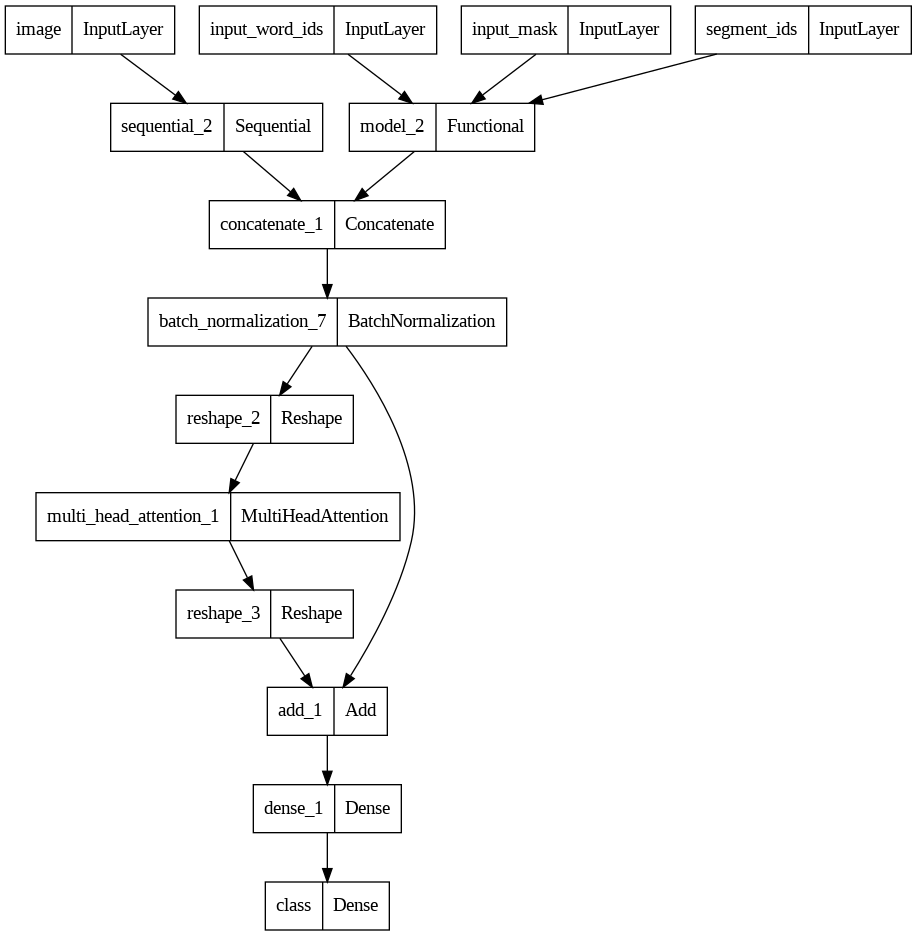

In [162]:
#do it not using the build model but rebuild without the function
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='multimodal.png')

In [ ]:
csv_logger = callbacks.CSVLogger('./stacking_early.log')
es = callbacks.EarlyStopping(patience = 3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

tuner = Hyperband(
    lambda hp: build_model(hp, seq_out=seq_out),
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='hyperparam_tuning',
    hyperband_iterations=1,
    #factor=3
)

train_steps = len(train) // batch_size
print(train_steps )
val_steps = len(val) // batch_size
tuner.search(
    x=data_train,
    epochs=10,
    #steps_per_epoch=train_steps,  # Ensure this is correctly calculated
    validation_data=data_val,
    #validation_steps=val_steps,   # Ensure this is correctly calculated
    callbacks=[csv_logger, reduce_lr],
    #batch_size=batch_size
)
tuner.results_summary()


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The best hyperparameters are:
    Dropout Rate: {best_hps.get('dropout')}
    learning_rate:{best_hps.get('learning_rate')}
    bilstm_units:{best_hps.get('lstm_units')}

""")


The best hyperparameters are:
    Dropout Rate: 0.4
    learning_rate:0.0001
    bilstm_units:256




In [ ]:
model = tuner.hypermodel.build(best_hps)
history=model.fit(data_train, epochs=50, validation_data=data_val)


Epoch 1/50
80/80 [==============================] - 136s 1s/step - loss: 11.9128 - accuracy: 0.7294 - val_loss: 10.5256 - val_accuracy: 0.8204
Epoch 2/50
80/80 [==============================] - 99s 1s/step - loss: 9.1862 - accuracy: 0.9252 - val_loss: 8.4572 - val_accuracy: 0.8244
Epoch 3/50
80/80 [==============================] - 99s 1s/step - loss: 7.1435 - accuracy: 0.9784 - val_loss: 6.8123 - val_accuracy: 0.8163
Epoch 4/50
80/80 [==============================] - 99s 1s/step - loss: 5.5505 - accuracy: 0.9909 - val_loss: 5.4722 - val_accuracy: 0.8335
Epoch 5/50
80/80 [==============================] - 99s 1s/step - loss: 4.2917 - accuracy: 0.9955 - val_loss: 4.4403 - val_accuracy: 0.8163
Epoch 6/50
80/80 [==============================] - 99s 1s/step - loss: 3.3102 - accuracy: 0.9953 - val_loss: 3.6602 - val_accuracy: 0.8103
Epoch 7/50
80/80 [==============================] - 99s 1s/step - loss: 2.5588 - accuracy: 0.9909 - val_loss: 2.9506 - val_accuracy: 0.8133
Epoch 8/50
80/80 

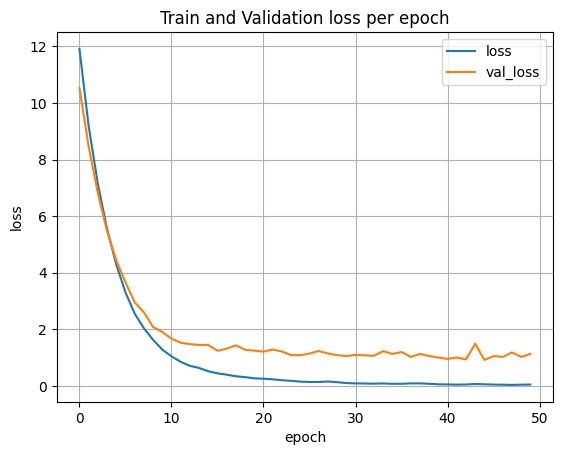

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(len(loss)),loss,label = 'loss')
plt.plot(range(len(val_loss)),val_loss,label = 'val_loss')
plt.grid(True)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation loss per epoch')
plt.savefig('./loss_model.jpg')
plt.show()



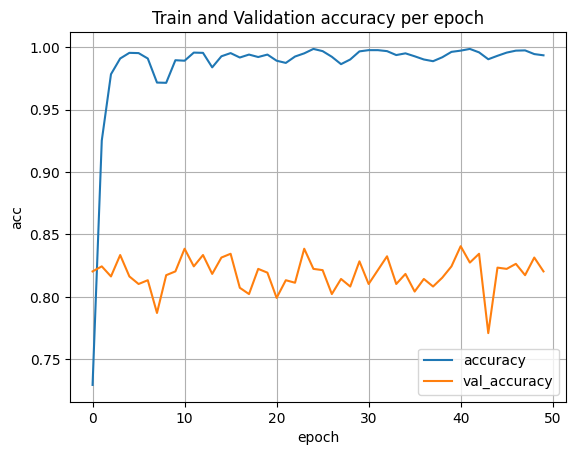

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(range(len(acc)),acc,label = 'accuracy')
plt.plot(range(len(val_acc)),val_acc,label = 'val_accuracy')
plt.grid(True)
plt.legend()
plt.title('Train and Validation accuracy per epoch')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./acc_model.jpg')
plt.show()

In [ ]:
# Images loading using tf.data
def tf_data_test(path, batch_size):
    paths = tf.data.Dataset.list_files(path)
    paths = paths.batch(64)
    dataset = paths.map(prepare_data, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    #dataset = dataset.repeat()
    return dataset

test_df = pd.read_table('/content/drive/MyDrive/data_test.tsv')

test_df["label"] = test_df["label"].apply(lambda x: change_label(x))
test =get_df(validation_df,"test")
data_test = tf_data_test('data/test/*/*.jpg', batch_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix
import seaborn as sns



# Assuming data_test is a preprocessed tf.data.Dataset object ready for evaluation
loss, accuracy = model.evaluate(data_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')





16/16 [==============================] - 7s 330ms/step - loss: 1.1325 - accuracy: 0.8204
Test Loss: 1.1325281858444214
Test Accuracy: 0.8203834295272827


In [ ]:
ip, op = next(iter(data_test))
images = ip['image'][:16]

input_masks = ip['input_mask'][:16]
input_word_ids = ip['input_word_ids'][:16]
input_segments = ip['segment_ids'][:16]

true_labels =  op['class']

In [ ]:

pred_labels = model.predict([input_word_ids,
                             input_masks,
                             input_segments,
                             images])

1/1 [==============================] - 6s 6s/step


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf

def get_all_predictions(data_test, model):
    true_labels = []
    pred_labels = []

    for ip, op in data_test:
        # Extracting inputs
        images = ip['image']
        input_masks = ip['input_mask']
        input_word_ids = ip['input_word_ids']
        input_segments = ip['segment_ids']

        # Extracting true labels
        batch_true_labels = np.argmax(op['class'].numpy(), axis=1)
        true_labels.extend(batch_true_labels)

        # Predicting and storing predicted labels
        batch_pred_probs = model.predict([input_word_ids, input_masks, input_segments, images])
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)
        pred_labels.extend(batch_pred_labels)

    return np.array(true_labels), np.array(pred_labels)

# Call the function to get all true and predicted labels
true_labels, pred_labels = get_all_predictions(data_test, model)

f1 = f1_score(true_labels, pred_labels, average='weighted')

print("F1 Score: ", f1)


1/1 [==============================] - 0s 46ms/step
F1 Score:  0.8124427104174402


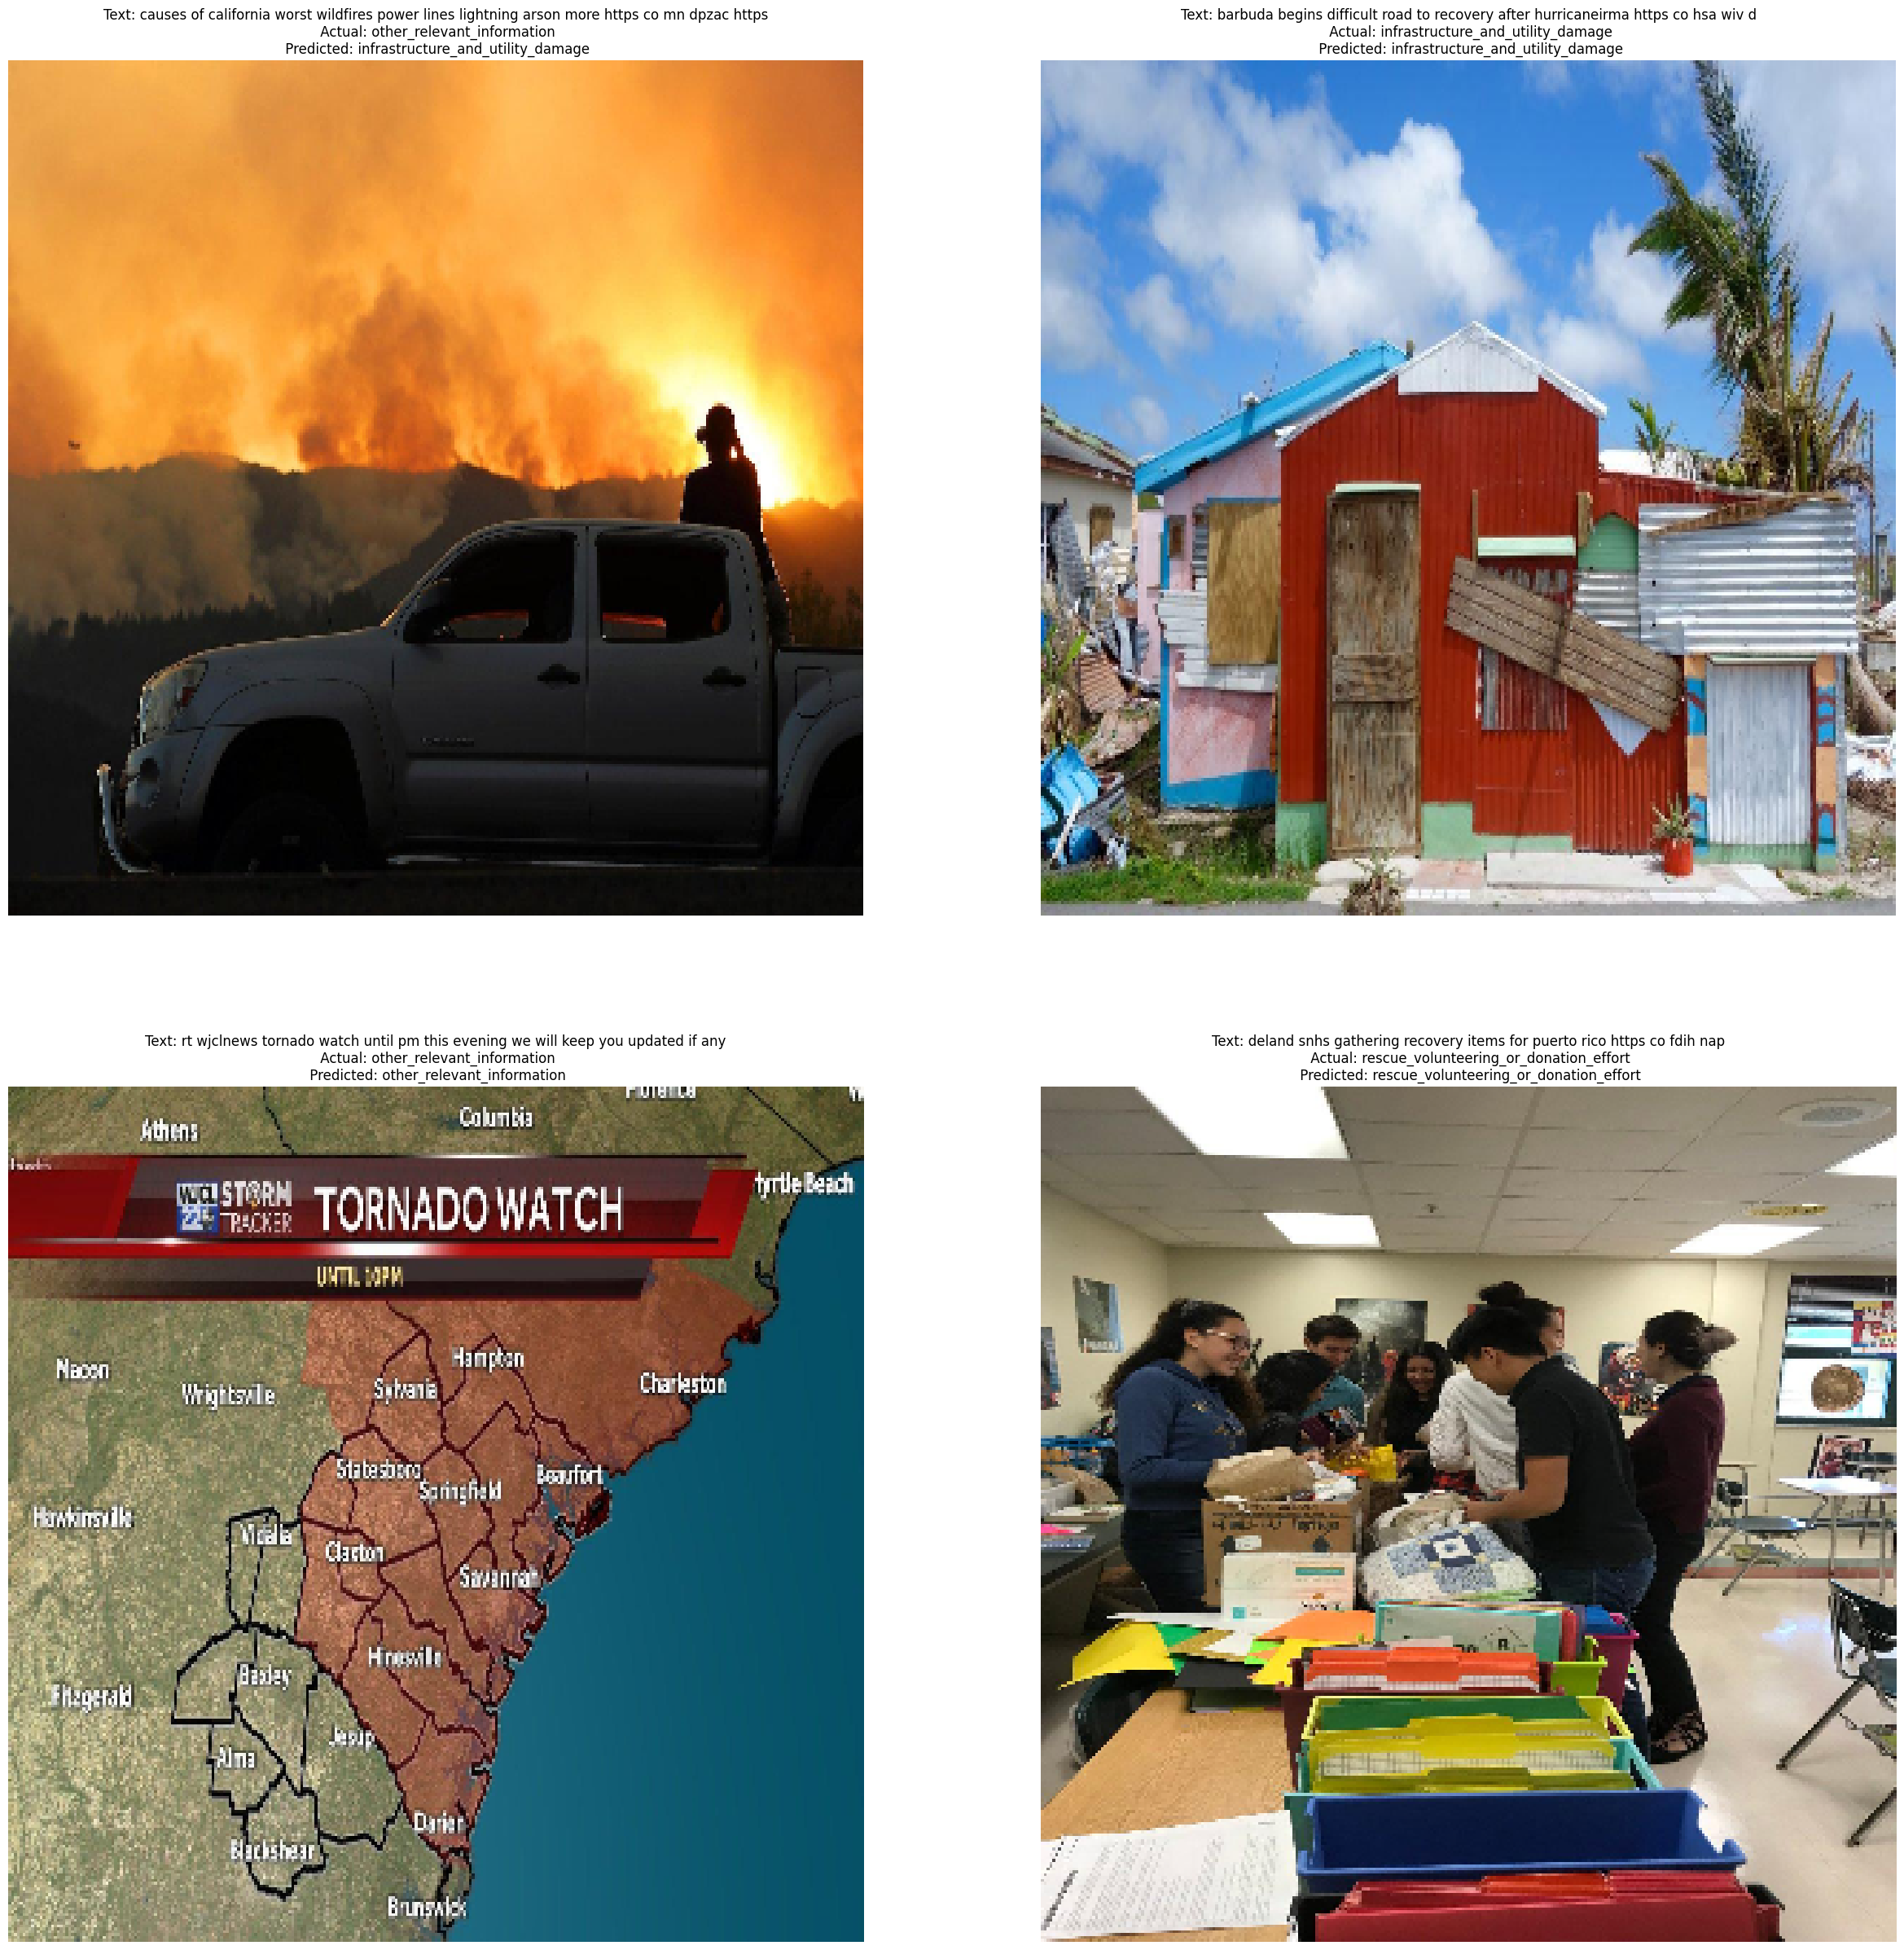

In [ ]:
i=1
texts = [clean_text(array) for array in input_word_ids.numpy()[:4]]
plt.figure(figsize=(30,30))
for image, actual_label, label, text in zip(images.numpy()[:4], true_labels.numpy()[:4], pred_labels, texts):
    plt.subplot(2,2,i)
    i+=1
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Text: {}\n Actual: {}\n Predicted: {}".format(text, Classes[actual_label.argmax(0)], Classes[label.argmax(0)]))
    plt.xlabel(text)
plt.show()

In [ ]:
base_model= MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
        layer.trainable = False
model_cnn = models.Sequential([
    base_model,
    GlobalAveragePooling2D(name='AVG_Pooling'),
    BatchNormalization(),  # Add BatchNormalization layer
    Dropout(0.4, name='Dropout'),
    Dense(128, activation='relu', name='Dense_128'),
    BatchNormalization(),  # Optionally add another BatchNormalization layer after the Dense layer
])